In [1]:
from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [2]:
# GLOBAL SETTINGS

# Data directories

#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
model_dataDir = 'DATA/MODELDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/STATINFER/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time periods settings
YEAR = 365

# Helpers
sns.set_style('darkgrid')
idx = pd.IndexSlice

# END GLOBAL SETTINGS

In [3]:
# HELPER FUNCTIONS

# Prediction vs Actual Scatter Plot
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

# Daily Information Coefficient(IC) Distribution
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

# Rolling Daily IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()   
# END HELPER FUNCTIONS

In [4]:
# Read in MDF with features
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)

# Filter out 60 and 90d columns
# Reason: Due to the relativly small size of the dataset, all the NaN values leave me with just 3 months of usable data.
# I could impute the NaNs but for such long time periods, I think this is too risky and could lead to false models
ninety_day_filter = model_mdf.filter(like='90d')
model_mdf = model_mdf.drop(ninety_day_filter.columns, axis=1)
sixty_day_filter = model_mdf.filter(like='60d')
#model_mdf = model_mdf.drop(sixty_day_filter.columns, axis=1)

# Impute missing entries in the remaining data (max 30d period seems reasonable)
model_mdf = model_mdf.groupby('Coin').apply(lambda x: x.fillna(x.mean()))

In [5]:
# Drop NaNs, OHLCV columns and lag period columns
data = model_mdf

data = (model_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))

data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

In [6]:
# Create X and Y values for the model
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)

In [7]:
drop_pca = data.filter(like='Principal')
X = X.drop(drop_pca.columns, axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30522 entries, (Timestamp('2020-01-01 00:00:00'), 'algorand') to (Timestamp('2022-01-14 00:00:00'), 'zcash')
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Volume      30522 non-null  float64
 1   RSI         30522 non-null  float64
 2   BB_high     30522 non-null  float64
 3   BB_low      30522 non-null  float64
 4   ATR         30522 non-null  float64
 5   MACD        30522 non-null  float64
 6   STOCH       30522 non-null  float64
 7   ADX         30522 non-null  float64
 8   DI_PLUS     30522 non-null  float64
 9   DI_MINUS    30522 non-null  float64
 10  return_1d   30522 non-null  float64
 11  return_7d   30522 non-null  float64
 12  return_14d  30522 non-null  float64
 13  return_30d  30522 non-null  float64
 14  return_60d  30522 non-null  float64
 15  year_2021   30522 non-null  int64  
 16  year_2022   30522 non-null  int64  
 17  month_2     30522 non-nu

In [8]:
# This is a custom implementation of TimeSeriesSplit CV from sklearn for finance data.
# It is taken from code developed by Stefen Jansen and Marcos Lopez de Prado.
# It is meant to eliminate any spill over between several train/test pairs derived from the dataset.
# Financial data is especially suseptible to such leakage and so a custom TimeSeries CV approach is necessary.
# The class below creates several train/test split pairs from the dataset and spearates them using
# purging, embargoing, and Combinatorial CV techniques.

class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'Coin' and 'Dates'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Dates').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Dates']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Dates > days[train_start])
                              & (dates.Dates <= days[train_end])].index
            test_idx = dates[(dates.Dates > days[test_start])
                             & (dates.Dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [9]:
# LINEAR REGRESSION MODELING

# Cross Validation
train_period_length = 30
test_period_length = 7
n_splits = int(2 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [10]:
# Train the model and make predictions
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()

try:
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
       
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]


        lr.fit(X=X_train, y=y_train)
        y_pred = lr.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='Dates')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        lr_scores.append(scores)
        lr_predictions.append(preds)


except IndexError:
    print('Ran out of data to make more train/test splits')


lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

Ran out of data to make more train/test splits


In [11]:
# Save results
lr_scores.to_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions.to_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
# Re-load results
lr_scores = pd.read_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')

In [12]:
# Evaluation
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 4.570% (p-value: 0.0000%)


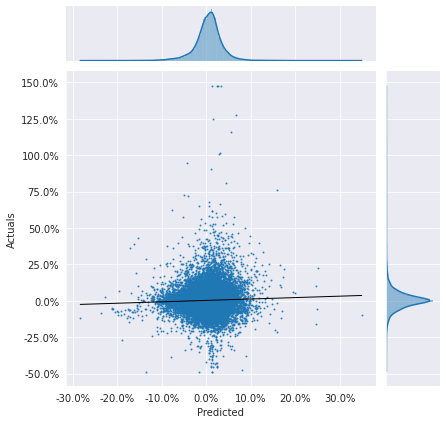

In [13]:
plot_preds_scatter(lr_predictions)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


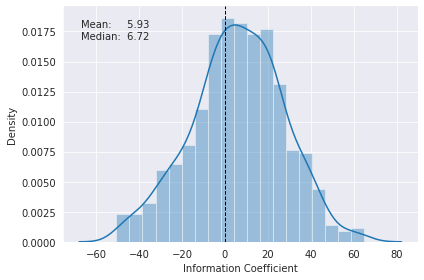

In [14]:
plot_ic_distribution(lr_scores)

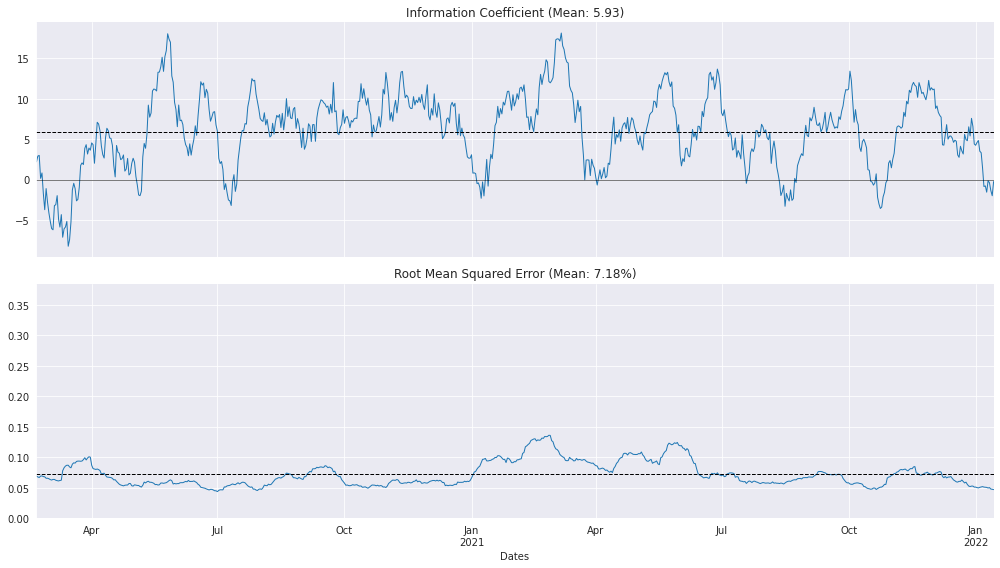

In [15]:
plot_rolling_ic(lr_scores)

In [16]:
# With Ridge Regression
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [17]:
n_splits = int(2 * YEAR/test_period_length)
train_period_length = 30
test_period_length = 7
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [18]:
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)
X = X.drop([c for c in X.columns if 'month' in c], axis=1)

In [19]:
# Cross Validation with Ridge
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')], axis=1)

            ridge_scores.append(scores.assign(alpha=alpha))
            ridge_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
            
    except IndexError: 
        print('Ran out of data for train/test splits')
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 Ran out of data for train/test splits
0.0005 Ran out of data for train/test splits
0.001 Ran out of data for train/test splits
0.005 Ran out of data for train/test splits
0.01 Ran out of data for train/test splits
0.05 Ran out of data for train/test splits
0.1 Ran out of data for train/test splits
0.5 Ran out of data for train/test splits
1.0 Ran out of data for train/test splits
5.0 Ran out of data for train/test splits
10.0 Ran out of data for train/test splits
50.0 Ran out of data for train/test splits
100.0 Ran out of data for train/test splits
500.0 Ran out of data for train/test splits
1000.0 Ran out of data for train/test splits
5000.0 Ran out of data for train/test splits
10000.0 Ran out of data for train/test splits
50000.0 Ran out of data for train/test splits




In [20]:


# Save the ridge results
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')

#  Reload the data
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')


In [21]:
# Evaluate the Ridge Results 
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 4.571% (p-value: 0.0000%)


In [22]:
# Ridge Alpha IC scores
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,714.0,5.623761,21.714026,-49.668990,-7.534843,5.827526,20.256969,65.644599
0.0005,714.0,5.624908,21.715345,-49.668990,-7.534843,5.827526,20.256969,65.644599
0.0010,714.0,5.625713,21.718051,-49.668990,-7.534843,5.827526,20.256969,65.644599
0.0050,714.0,5.625688,21.716355,-49.668990,-7.534843,5.827526,20.256969,65.644599
0.0100,714.0,5.625854,21.715366,-49.668990,-7.504355,5.827526,20.256969,65.644599
0.0500,714.0,5.636590,21.723455,-49.668990,-7.700348,5.827526,20.256969,65.644599
0.1000,714.0,5.652767,21.730540,-49.668990,-7.700348,5.975610,20.270035,65.644599
0.5000,714.0,5.671262,21.771119,-49.285714,-7.630662,5.879791,20.169861,65.644599
1.0000,714.0,5.688144,21.801887,-49.285714,-7.582753,5.801394,20.361498,65.940767


In [23]:
ridge_scores.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12852 entries, 2022-01-08 to 2020-02-07
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ic      12852 non-null  float64
 1   rmse    12852 non-null  float64
 2   alpha   12852 non-null  float64
dtypes: float64(3)
memory usage: 401.6 KB


In [24]:
ridge_scores.columns

Index(['ic', 'rmse', 'alpha'], dtype='object')

In [25]:
ridge_scores[ridge_scores.index.duplicated()]

,ic,rmse,alpha
Dates,,,
2022-01-08,15.505226,2.995104e-02,0.0005
2022-01-09,-17.108014,3.668899e-02,0.0005
2022-01-10,5.069686,4.960298e-02,0.0005
2022-01-11,26.864111,4.961923e-02,0.0005
2022-01-12,-1.219512,3.368707e-02,0.0005
...,...,...,...
2020-02-03,34.825784,1.205477e+12,50000.0000
2020-02-04,-49.198606,1.109636e+12,50000.0000
2020-02-05,53.484321,1.108759e+12,50000.0000


In [26]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
ridge_scores['Dates'] = ridge_scores.index
len_df = ridge_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
ridge_scores.index = temp_new_index

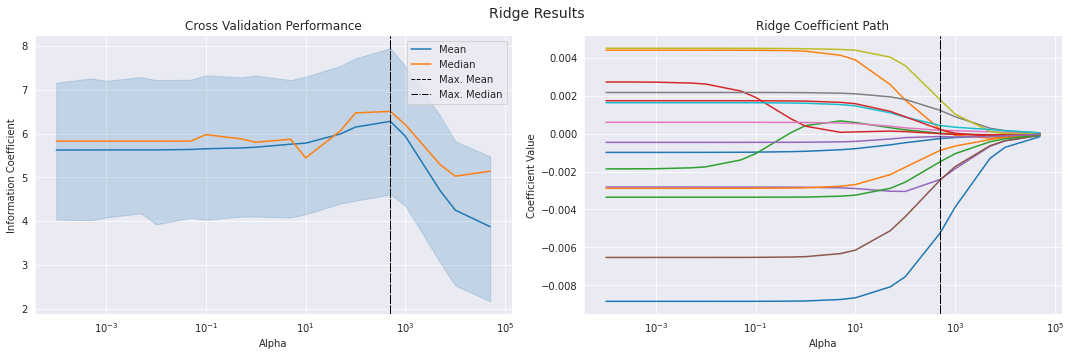

In [27]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()



ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [28]:
# Switch the index back to DateTimeIndex
ridge_scores.index = ridge_scores['Dates']
ridge_scores.drop(['Dates'], axis = 1,inplace=True)

In [29]:
print(ridge_scores.columns)

Index(['ic', 'rmse', 'alpha'], dtype='object')


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


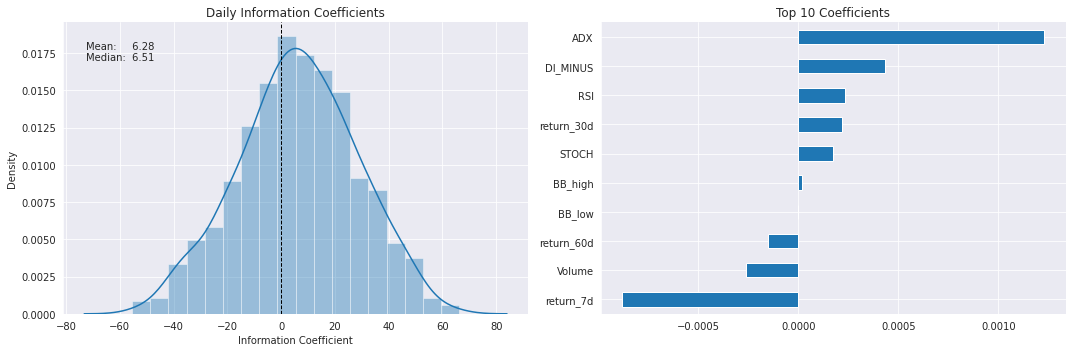

In [30]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

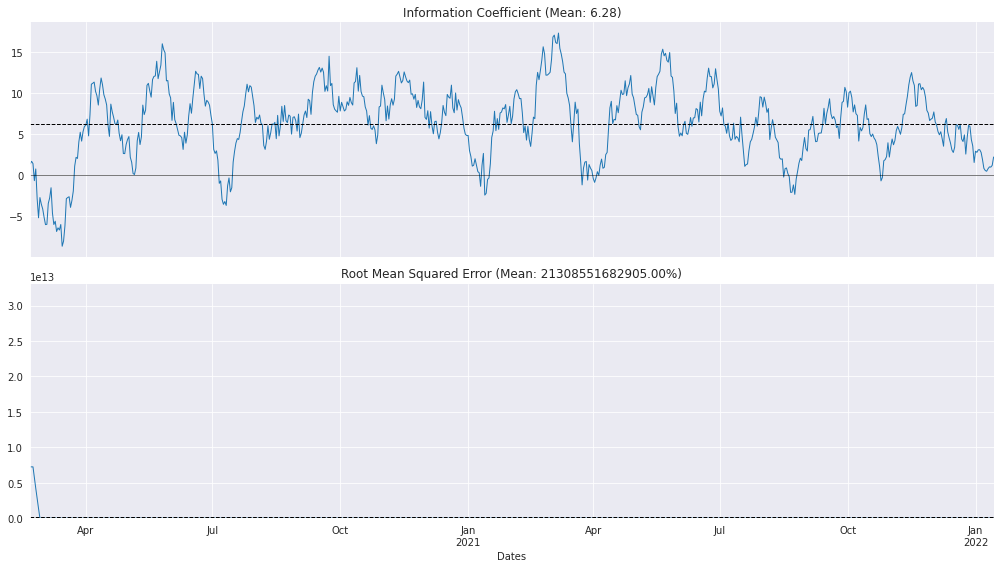

In [31]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

In [32]:
ridge_scores.alpha.iloc[714:1428]

Dates
2022-01-08    0.0005
2022-01-09    0.0005
2022-01-10    0.0005
2022-01-11    0.0005
2022-01-12    0.0005
               ...  
2020-02-03    0.0005
2020-02-04    0.0005
2020-02-05    0.0005
2020-02-06    0.0005
2020-02-07    0.0005
Name: alpha, Length: 714, dtype: float64

In [33]:
# With Lasso Regression

# CV parameters
lasso_alphas = np.logspace(-10, -3, 8)

train_period_length = 30
test_period_length = 7
YEAR = 365
n_splits = int(2 * YEAR / test_period_length) # two years
lookahead = 1


In [34]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [35]:
# Lasso Cross-validation
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)
X = X.drop([c for c in X.columns if 'month' in c], axis=1)

In [36]:
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            t = time()
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')],
                               axis=1)

            lasso_scores.append(scores.assign(alpha=alpha))
            lasso_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
    except IndexError: 
        print('Ran out of data for train/test splits')
        lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+00, tolerance: 3.167e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+00, tolerance: 3.829e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e+00, tolerance: 4.837e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+00, tolerance: 4.748e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.658e+00, tolerance: 2.021e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.519e+00, tolerance: 1.376e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e+00, tolerance: 6.134e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+00, tolerance: 6.060e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.338e+00, tolerance: 3.011e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.112e+00, tolerance: 1.145e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
1e-09 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+00, tolerance: 5.014e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e+00, tolerance: 4.226e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e+00, tolerance: 4.079e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+00, tolerance: 4.513e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.979e+00, tolerance: 1.376e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.592e+00, tolerance: 1.593e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+00, tolerance: 5.324e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+00, tolerance: 4.252e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
1e-08 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+00, tolerance: 5.014e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e+00, tolerance: 4.226e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+00, tolerance: 4.713e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+00, tolerance: 4.837e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.950e+00, tolerance: 1.376e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.914e-01, tolerance: 1.593e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.662e-02, tolerance: 4.252e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e+00, tolerance: 3.961e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
1e-07 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.399e+00, tolerance: 5.014e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e+00, tolerance: 4.226e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+00, tolerance: 4.426e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.574e+00, tolerance: 5.947e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-01, tolerance: 4.431e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e+00, tolerance: 4.781e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e+00, tolerance: 3.609e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+00, tolerance: 4.140e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
1e-06 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+00, tolerance: 4.615e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e+00, tolerance: 4.144e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.798e-01, tolerance: 4.837e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.976e-01, tolerance: 4.513e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.991e-01, tolerance: 4.206e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.710e-01, tolerance: 4.837e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e-01, tolerance: 3.453e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.808e-01, tolerance: 1.145e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
1e-05 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e+00, tolerance: 5.014e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e+00, tolerance: 4.226e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.894e-02, tolerance: 4.657e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e-01, tolerance: 6.134e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
0.0001 Ran out of data for train/test splits
0.001 Ran out of data for train/test splits


In [37]:
# Persist Lasso outputs
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf(f'{model_dataDir}Lasso_Coeffs.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf(f'{model_dataDir}Lasso_Predictions_Scores.h5', 'lasso/predictions')



In [38]:
# Results
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 5.233% (p-value: 0.0000%)


In [39]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,5.682858,5.696864
1.000000e-09,5.682858,5.696864
1.000000e-08,5.681784,5.635889
1.000000e-07,5.680637,5.635889
1.000000e-06,5.676547,5.705575
1.000000e-05,5.663842,5.775261
1.000000e-04,5.766415,5.601045
1.000000e-03,6.046468,6.628920


In [40]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
lasso_scores['Dates'] = lasso_scores.index
len_df = lasso_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
lasso_scores.index = temp_new_index

In [41]:
lasso_scores.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712],
           dtype='int64', length=5712)

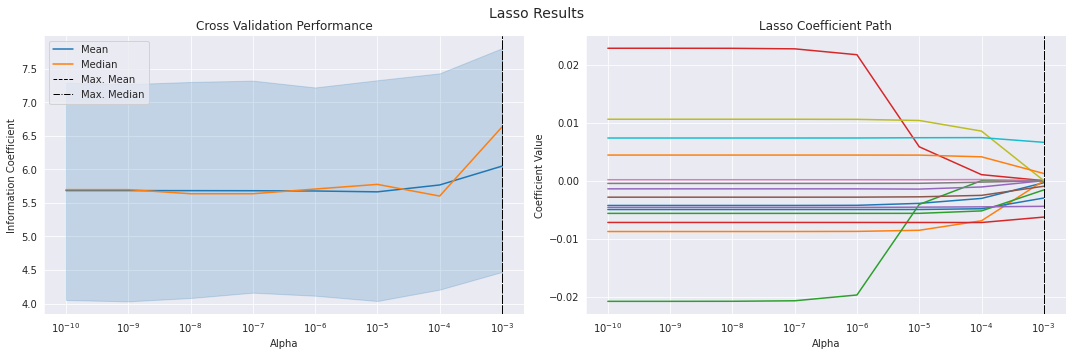

In [42]:
# Lasso Coefficient paths
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

In [43]:
# Switch the index back to DateTimeIndex
lasso_scores.index = lasso_scores['Dates']
lasso_scores.drop(['Dates'], axis = 1,inplace=True)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


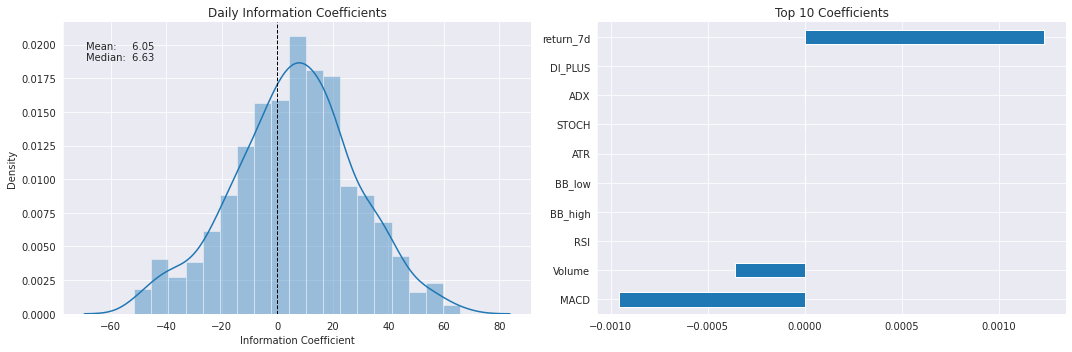

In [44]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

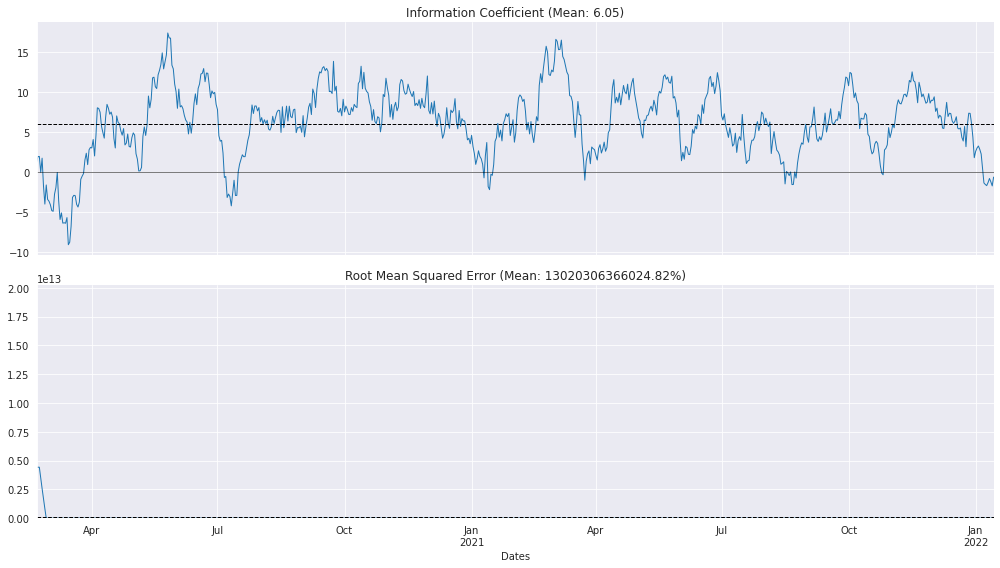

In [45]:
plot_rolling_ic(lasso_scores[lasso_scores.alpha==best_alpha])

In [46]:
# Compare results
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [47]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [48]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

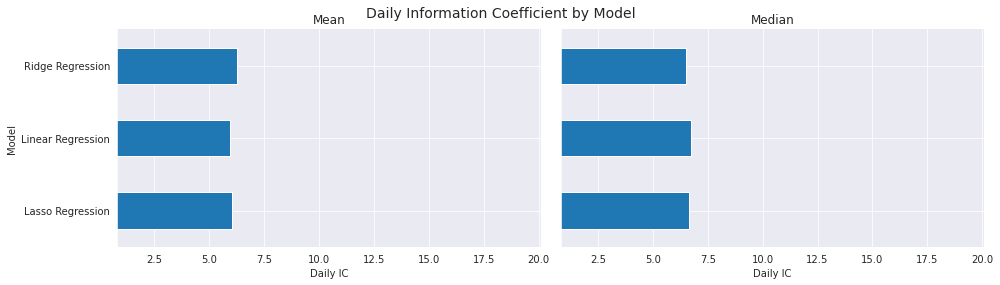

In [49]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(0.85, 20), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(0.8, 20.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)